In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import time

sys.path.append("..")
from utils.configuration import Configuration
from finn import *

In [2]:
print_progress=True
visualize=True
model_number=None

In [3]:
def animate_1d(t, axis1, axis2, field, field_hat):
    """
    Data animation function animating an image over time.
    :param t: The current time step
    :param axis: The matplotlib image object
    :param field: The data field
    :return: The matplotlib image object updated with the current time step's
        image date
    """
    axis1.set_ydata(field[:, t])
    axis2.set_ydata(field_hat[:, t])


def animate_2d(t, im1, im2, u_hat, u):
    """
    Data animation function animating an image over time.
    :param t: The current time step
    :param axis: The matplotlib image object
    :param field: The data field
    :return: The matplotlib image object updated with the current time step's
        image date
    """
    im1.set_array(u_hat[t,:,:].squeeze().t().detach())
    im2.set_array(u[t,:,:].squeeze().t().detach())

In [4]:
# Load the user configurations
config = Configuration("config.json")

# Append the model number to the name of the model
if model_number is None:
    model_number = config.model.number
config.model.name = config.model.name + "_" + str(model_number).zfill(2)

# Print some information to console
print("Model name:", config.model.name)

# Hide the GPU(s) in case the user specified to use the CPU in the config
# file
if config.general.device == "CPU":
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

root_path = os.path.abspath("../../data")
data_path = os.path.join(root_path, config.data.type, config.data.name)

# Set device on GPU if specified in the configuration file, else CPU
device = th.device(config.general.device)


# Load samples, together with x, y, and t series
t = th.tensor(np.load(os.path.join(data_path, "t_series.npy")),
                dtype=th.float).to(device=device)
x = np.load(os.path.join(data_path, "x_series.npy"))
sample_c = th.tensor(np.load(os.path.join(data_path, "sample_c.npy")),
                        dtype=th.float).to(device=device)
sample_ct = th.tensor(np.load(os.path.join(data_path, "sample_ct.npy")),
                        dtype=th.float).to(device=device)

dx = x[1]-x[0]
u = th.stack((sample_c, sample_ct), dim=len(sample_c.shape))
u[1:] = u[1:] + th.normal(th.zeros_like(u[1:]),th.ones_like(u[1:])*config.data.noise)

# Initialize and set up the model
if "test" in config.data.name:
    bc = np.array([[0.7, 0.7], [0.0, 0.0]])
else:
    bc = np.array([[1.0, 1.0], [0.0, 0.0]])
    
model = FINN_DiffSorp(
    u = u,
    D = np.array([0.5, 0.1]),
    BC = bc,
    dx = dx,
    layer_sizes = config.model.layer_sizes,
    device = device,
    mode="test",
    learn_coeff=True
).to(device=device)


# Count number of trainable parameters
pytorch_total_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable model parameters: {pytorch_total_params}\n")

# Load the trained weights from the checkpoints into the model
model.load_state_dict(th.load(os.path.join(os.path.abspath(""),
                                            "checkpoints",
                                            config.model.name,
                                            config.model.name+".pt")))

model.eval()

# Initialize the criterion (loss)
criterion = nn.MSELoss()

#
# Forward data through the model
time_start = time.time()
with th.no_grad():
    u_hat = model(t=t, u=u)
if print_progress:
    print(f"Forward pass took: {time.time() - time_start} seconds.")
u_hat = u_hat.detach().cpu()
u = u.cpu()
t = t.cpu()

pred = np.array(u_hat)
labels = np.array(u)

# Compute error
mse = criterion(u_hat, u).item()
print(f"MSE: {mse}")

Model name: diff-sorp_02
Trainable model parameters: 464

Forward pass took: 0.45395398139953613 seconds.
MSE: 1.86355464393273e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


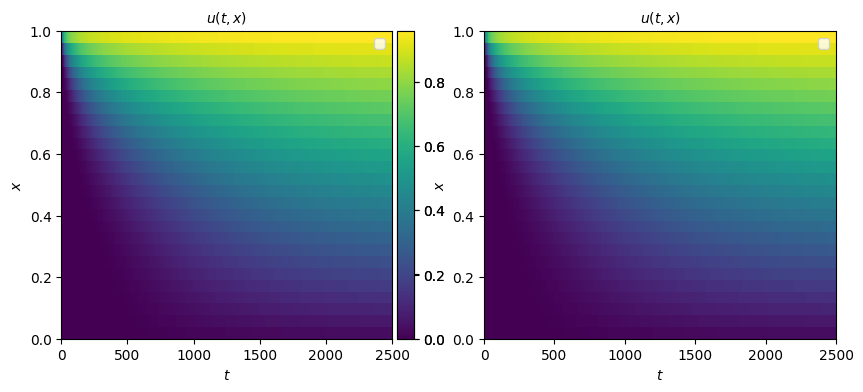

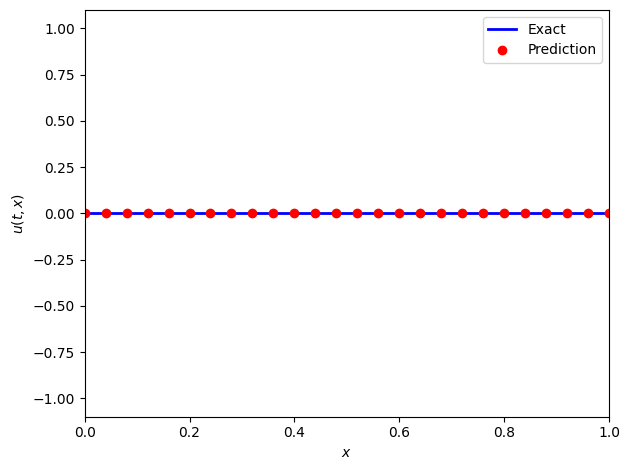

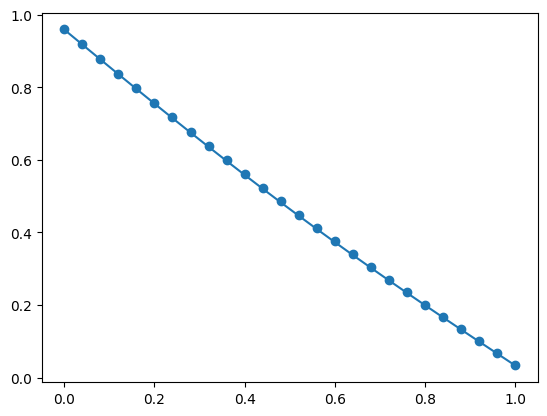

In [5]:
#
# Visualize the data

u_hat = np.transpose(u_hat[...,0])
u = np.transpose(u[...,0])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# u(t, x) over space
h = ax[0].imshow(u, interpolation='nearest', 
                extent=[t.min(), t.max(),
                        x.min(), x.max()],
                origin='upper', aspect='auto')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax[0].set_xlim(0, t.max())
ax[0].set_ylim(x.min(), x.max())
ax[0].legend(loc="upper right")
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$x$')
ax[0].set_title('$u(t,x)$', fontsize = 10)

h = ax[1].imshow(u_hat, interpolation='nearest', 
                extent=[t.min(), t.max(),
                        x.min(), x.max()],
                origin='upper', aspect='auto')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax[1].set_xlim(0, t.max())
ax[1].set_ylim(x.min(), x.max())
ax[1].legend(loc="upper right")
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$x$')
ax[1].set_title('$u(t,x)$', fontsize = 10)

# u(t, x) over time
fig, ax = plt.subplots()
line1, = ax.plot(x, u[:, 0], 'b-', linewidth=2, label='Exact')
line2, = ax.plot(x, u_hat[:, 0], 'ro', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_xlim([x.min(), x.max()])
ax.set_ylim([-1.1, 1.1])
ax.legend()

anim = animation.FuncAnimation(fig,
                                animate_1d,
                                frames=len(t),
                                fargs=(line1, line2, u, u_hat),
                                interval=20)
plt.tight_layout()
plt.draw()
# plt.show()

plt.figure()
plt.plot(x,u_hat[:,-1])
plt.scatter(x,u[:,-1])


RETARDATION_FACTOR_FUNCTION = "freundlich"  # "linear", "freundlich", "langmuir"
DIFFUSION_COEFFICIENT = 0.0005
POROSITY = 0.29
RHO_S = 2880
K_F = 1.016/RHO_S
N_F = 0.874
S_MAX = 1/1700
KL = 1
KD = 0.429/1000
SOLUBILITY = 1.0
T_MAX = 2500
T_STEPS = 501

X_LEFT = 0.0
X_RIGHT = 1.0
X_STEPS = 13

import sys
sys.path.append("/Users/r/Documents/stud/ss24/p3inn_finn/src/finn/data/diffusion_sorption/")
from simulator import Simulator
simulator = Simulator(
ret_factor_fun=RETARDATION_FACTOR_FUNCTION,
diffusion_coefficient=DIFFUSION_COEFFICIENT,
porosity=POROSITY,
rho_s=RHO_S,
k_f=K_F,
n_f=N_F,
s_max=S_MAX,
kl=KL,
kd=KD,
solubility=SOLUBILITY,
t_max=T_MAX,
t_steps=T_STEPS,
x_left=X_LEFT,
x_right=X_RIGHT,
x_steps=X_STEPS,
train_data=True
)

[0.         0.01198626 0.02455688 0.03775406 0.05162501 0.06622386
 0.0816133  0.09786725 0.11507106 0.13332653 0.15275645 0.17350817
 0.19576406]


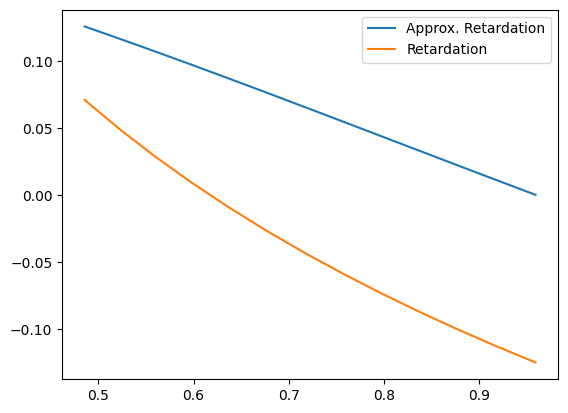

In [6]:

fig, ax = plt.subplots()

c = u[:simulator.Nx, -1]
# print(c.shape)
# print(simulator.retardation(c).shape)
# exit()
ret_exact = (simulator.retardation(c)).detach().numpy()
print("="*100)
print(ret_exact - ret_exact[0])
print("="*100)
ret_inv = ((model.func_nn(c.unsqueeze(-1)) * 10**model.p_exp)[...,0]).detach().numpy()
ret_approx = 1/ret_inv
ax.plot(c, (ret_approx  - ret_approx[0]), "-", label="Approx. Retardation")
ax.plot(c, (ret_exact - ret_exact[0] - 0.125), label="Retardation")
#     ax.plot(c, ret_exact, label="Retardation")
#     ax.plot(c, ret_approx, "-", label="Approx. Retardation")

# from finn.pdf page 16
# phi = 0.29
# rho_s = 2880
# k = 3.5e-4
# nf = 0.874
# R = 1 + (1-phi)/phi * rho_s * k * nf * c**(nf - 1)
# ax.plot(c, R, label="Approx. Retardation2")
ax.legend()
plt.show()

In [7]:
ret_inv

array([0.29680714, 0.29584876, 0.29489273, 0.2939423 , 0.2930009 ,
       0.29207167, 0.2911578 , 0.2902622 , 0.2893876 , 0.28853652,
       0.28771123, 0.2869137 , 0.28614554], dtype=float32)